In [115]:
import geojson
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
from PIL import Image
import rasterio as rs
from rasterio.plot import show
from rasterio import warp
from skimage import morphology
from skimage.feature import blob_doh
from tqdm.notebook import tqdm

In [2]:
def pixels_to_coords(x, y, src_img):
    lon, lat = warp.transform(src_img.crs, rs.crs.CRS.from_epsg(4326), [src_img.xy(x, y)[0]], [src_img.xy(x, y)[1]])
    return lon[0], lat[0]

def coords_to_pixels(lon, lat, src_img):
    x, y = warp.transform(rs.crs.CRS.from_epsg(4326), src_img.crs, [lon],  [lat])
    pixel_y, pixel_x = src_img.index(x, y)
    return pixel_x[0], pixel_y[0]

In [141]:
source = rs.open('../data/model_outputs/tpa_nn_toa_main_island_median.tif')

In [143]:
from rasterio.windows import Window
preds_median = source.read(1, window=window) / 255

In [203]:
np.append(np.array(transform * [candidate[1], candidate[0]]), candidate[2])

array([114.59633005,  -8.5504045 ,   2.        ])

In [207]:
window_size = 5000
candidate_sites = []
for x in tqdm(range(0,source.shape[0],window_size)):
    for y in tqdm(range(0,source.shape[1],window_size)):
        # Set min and max to analyze a subset of the image
        window = Window.from_slices((x,x + window_size), (y, y + window_size))
        window_median = source.read(1, window=window) / 255
        # mask predictions below a threshold
        mask = np.ma.masked_where(window_median < 0.5, window_median).mask
        window_median[mask] = 0

        # detect blobs
        blobs = blob_doh(window_median, min_sigma=5, max_sigma=100, threshold=.015)
        
        transform = source.window_transform(window)
        candidate_coords = [np.append(np.array(transform * [candidate[1], candidate[0]]), candidate[2]) for candidate in blobs]
        if len(candidate_coords) > 0:
            for site in candidate_coords:
                candidate_sites.append(site)
    print(len(candidate_sites), "candidate sites detected so far")
    pd.DataFrame(candidate_sites, columns=['lon', 'lat', 'size']).to_csv('../data/model_outputs/candidate_sites/v12_java_candidates_0.8_threshold.csv')


103 candidate sites detected so far



217 candidate sites detected so far



471 candidate sites detected so far


KeyboardInterrupt: 

In [172]:
import json
json_points = json.dumps(candidate_sites)

In [174]:
# Plot blob locations on a satellite base image
from keplergl import KeplerGl
candidate_map = KeplerGl(data={'candidates': json_points})

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [164]:
# Plot blob locations on a satellite base image
from keplergl import KeplerGl
candidate_map = KeplerGl(data={'coords':pd.DataFrame([0,1])})

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


## Extract Vector Boundary

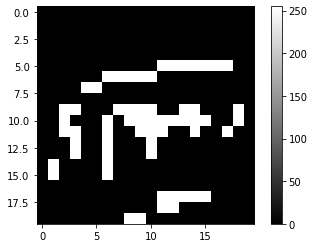

In [99]:
plt.imshow(thresh, cmap='gray')
plt.colorbar()

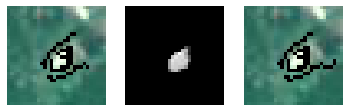

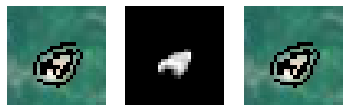

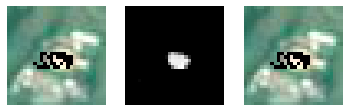

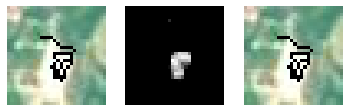

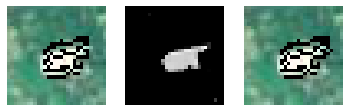

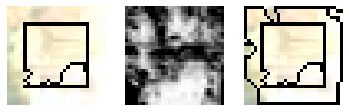

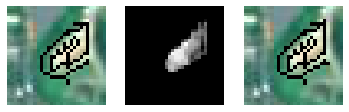

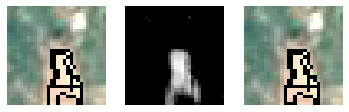

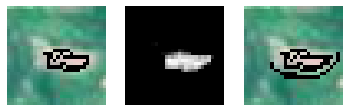

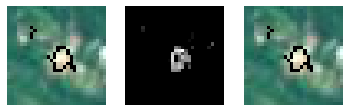

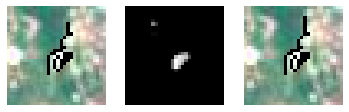

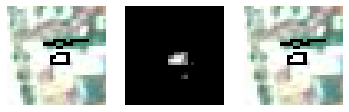

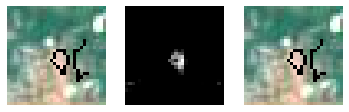

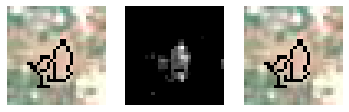

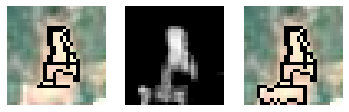

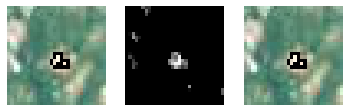

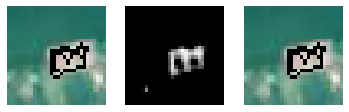

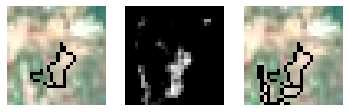

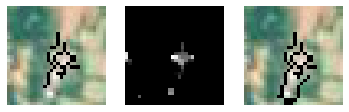

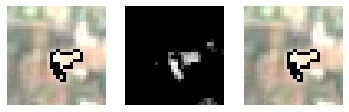

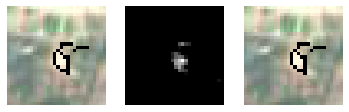

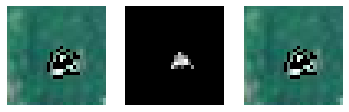

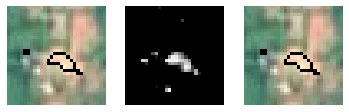

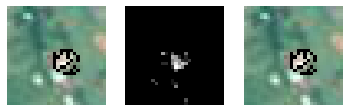

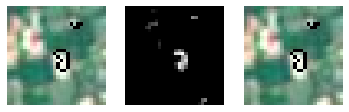

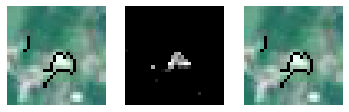

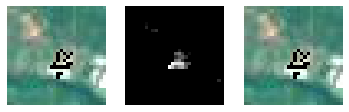

In [102]:
width = 15
for blob in blobs:
    x = int(blob[0])
    y = int(blob[1])
    crop_pred = preds_median[x - width : x + width, y - width : y + width]
    crop_rgb = satellite_img[x - width : x + width, y - width : y + width]
    
    preds = (crop_pred * 255).astype('uint8')
    ret, thresh = cv2.threshold(preds, int(255 * 0.5), 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    largest_contours = sorted(contours, key=cv2.contourArea)[-1:]
    
    
    plt.subplot(1,3,1)
    plt.imshow(crop_rgb)
    plt.axis('off')
    
    plt.subplot(1,3,2)
    plt.imshow(crop_pred, cmap='gray', vmin=0.5)
    plt.axis('off')
    
    plt.subplot(1,3,3)
    plt.imshow(cv2.drawContours(crop_rgb, largest_contours, 0, (1,0,0), 1))
    plt.axis('off')
    
    plt.show()

## Write Points to geojson

In [104]:
candidate_points = []
for i, blob in enumerate(blobs):
    candidate_points.append(geojson.Feature(geometry = geojson.Point(pixels_to_coords(blob[0], blob[1], source)),
                                            properties={'name': f"Point {i}"}))

feature_collection = geojson.FeatureCollection(candidate_points)

fc_dump = geojson.dumps(feature_collection)
with open('../web_map/candidate_points_v12.geojson', 'w') as f:
    f.write(fc_dump)

In [345]:
tpa_points = []
for index in range(len(tpa_sites)):
    site=tpa_sites.iloc[index]
    tpa_points.append(geojson.Feature(geometry=geojson.Point(site['coords']),
                                      properties={'name': site['name']}
                                     ))
tpa_collection = geojson.FeatureCollection(tpa_points)

tpa_dump = geojson.dumps(tpa_collection)
with open('../web_map/tpa_coords.geojson', 'w') as f:
    f.write(tpa_dump)

## Experimental filtering method (top hat transform)

In [ ]:
disk_size = 1
selem =  morphology.disk(disk_size)
res = morphology.white_tophat(img, selem)
filtered_img = img - res
plt.figure(figsize=(12,12), dpi=300)
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Top Hat Transform: Disk Size ' + str(disk_size))
plt.subplot(1,2,2)
plt.imshow(filtered_img, cmap='gray', vmin=0, vmax=1, interpolation='none')
plt.axis('off')
plt.title('Top Hat Transform: Disk Size ' + str(disk_size))
plt.show()

## Bali Specific

In [24]:
# Load known TPA dataset
with open('../data/tpa_points.json') as f:
    tpa_points = json.load(f)
    f.close()

tpa_sites = pd.DataFrame({
    'name': [site['properties']['Name'] for site in tpa_points['features']],
    'lon': [site['geometry']['coordinates'][0] for site in tpa_points['features']],
    'lat': [site['geometry']['coordinates'][1] for site in tpa_points['features']],
    'area': [site['properties']['Surface_Ha'] for site in tpa_points['features']],
    'daily_volume': [site['properties']['TOT_Kg/Day'] for site in tpa_points['features']],
    'coords': [site['geometry']['coordinates'] for site in tpa_points['features']]
})

In [95]:
satellite_img = np.array(Image.open('../../bali_webmerc_clip.jpg'))

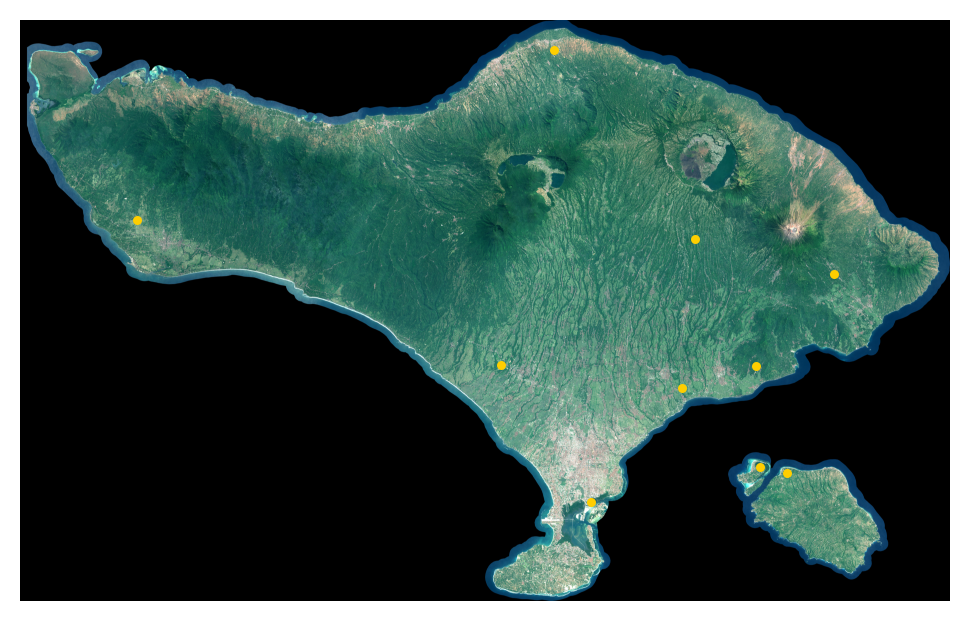

In [96]:
plt.figure(dpi=200)
plt.imshow(satellite_img)
for lon, lat in zip(tpa_sites['lon'], tpa_sites['lat']):
    x, y = coords_to_pixels(lon, lat, source)
    plt.scatter(x, y, c='#FFCE00', s=5)
plt.axis('off')
plt.show()

In [6]:
plt.figure(figsize=(20,20), dpi=200)
plt.imshow(preds_median, cmap='gray')
plt.axis('off')
plt.show()

KeyboardInterrupt: 